In [1]:
import numpy as np
import random
import scipy
import freud
import gsd.hoomd
import warnings
warnings.filterwarnings('ignore')

# Initializing Polymer Chains

This notebook is meant to initialize a system of polymer chains with the following parameters specified:
- Number of monomers per chain: $N$
- Monomer diameter: $\sigma$
- Equilibrium bond distance: $r_0$
- Number of chains: $M$
- System packing fraction: pf
- Radius multiplier which determines percent overlaps: overlap_window 

The initialized system is then written to a gsd file. Note that the user will have to relax the polymer system, and example of which is provided in the Tutorial - MD - Polymer Relaxation.ipynb hoomd example.  

## System Parameters

Reasonable values for the variables in the following cell will vary between simulations. Here, we are initializing a system with a packing fraction of 0.7. 

The overlap_window variable defines the amount of monomer overlaps you want to accept in the initialization of this system. This variable is a multiplier to the particle radius in the overlap check. Therefore, for dense systems, this variable should be $<1$ to allow for overlaps. Because we are creating a dilute system, however, the overlap_window is $>1$, assuming all of the chains can be easily placed without overlaps. 

In [2]:
# specify parameters 
pf = 0.7 # packing fraction
sigma = 1 # particle diameter
r_0=1.1*sigma # eq bond distance
overlap_window = 0.6
N = 100 # monomers per chain
M = 10 # number of chains
filename = 'init.gsd' # filename

# Compute system box dimension
V = (4/3)*np.pi*(sigma/2)**3 # monomer volume
V_tot = V*N*M # total monomer volume
V_box = V_tot/pf # box volume
l_box = V_box**(1/3) # box length (cubic box)

## Create Polymer System

The basic schema for initializing our random polymer system is as follows:
- Loop over the number of desired polymer chains
- For each chain, loop over the desired number of monomers
- Place a monomer randomly for the initial chain position
- Grow the chain by adding monomers one at a time in random directions separated by the equilibrium bond distance, checking for particle overlaps at each addition
- After all chains have been created, write the system to a gsd file 

In [3]:
# Smaller box size to avoid periodic boundary issues
l_box2 = 0.95*l_box

# Box struture
box = freud.box.Box(Lx=l_box2,Ly=l_box2,Lz=l_box2)

# Master list of points
pts_full = [[-2*l_box2,-2*l_box2,-2*l_box2]]

# Bond list
bond_full = []

# Type ID array
type_full = []

# Diameter array
diameter_full = []

# Molecule ID array
ID_full = []

# Start placing chains
M_counter = 0

# Index counter 
indx_particle = 0

while M_counter < M:       
    
    # Intialize chain
    chain_tmp = []
    chain_counter = len(chain_tmp)
    
    # Loop over chain length
    while len(chain_tmp) < N:
        
        # First point
        if len(chain_tmp) == 0:
            # Pick initial position
            x_tmp = random.uniform(-l_box2/2.0,l_box2/2.0) 
            y_tmp = random.uniform(-l_box2/2.0,l_box2/2.0)
            z_tmp = random.uniform(-l_box2/2.0,l_box2/2.0)
            tmp = np.array([x_tmp,y_tmp,z_tmp])
        # All other points
        else:
            # Ensure that new monomer being added is inside box
            flag_outside = 1
            while flag_outside == 1:
                # Pick growth direction
                x_tmp = random.uniform(-l_box2/2.0,l_box2/2.0) 
                y_tmp = random.uniform(-l_box2/2.0,l_box2/2.0)
                z_tmp = random.uniform(-l_box2/2.0,l_box2/2.0)
                # Determine growth normal vector
                nv_tmp = np.array([x_tmp,y_tmp,z_tmp])
                nv_tmp = nv_tmp/np.linalg.norm(nv_tmp)
                # Grow chain
                x_add = chain_tmp[-1][0] + nv_tmp[0]*r_0
                y_add = chain_tmp[-1][1] + nv_tmp[1]*r_0
                z_add = chain_tmp[-1][2] + nv_tmp[2]*r_0
                # Check if outside box
                if ( (abs(x_add) < l_box2/2.0) and (abs(y_add) < l_box2/2.0) and (abs(z_add) < l_box2/2.0) ):
                    flag_outside = 0                
            tmp = np.array([x_add,y_add,z_add])
                                
        # Check overlap
        query = freud.locality.AABBQuery(box, np.array(pts_full))
        tmp_check = query.query(tmp,{'r_max':overlap_window*sigma})

        # Add monomer
        if len(list(tmp_check)) == 0:
            # Update full xyz list
            pts_full.append(tmp)
            # Update chain list
            chain_tmp.append(tmp)
            # Update chain counter
            chain_counter = chain_counter + 1
            # Update bonds
            if len(chain_tmp) > 1:
                # Bond structure
                tmp_bond = [indx_particle-1,indx_particle]
                # Add to bond list
                bond_full.append(tmp_bond)            
            # Update index counter
            indx_particle = indx_particle + 1
            # Update type id
            type_full.append(0)
            # Update diameter
            diameter_full.append(sigma)
            # Update molecule ID
            ID_full.append(M_counter)
    
    # Update M_counter
    M_counter += 1
    print(M_counter, 'chains have been created')

pts_final = pts_full[1:]

print('Writing to GSD')

# Write to gsd file
s = gsd.hoomd.Snapshot()
s.particles.N = len(pts_final)
s.particles.typeid = type_full
s.particles.position = pts_final
s.particles.diameter = diameter_full
s.particles.charge = ID_full
s.configuration.box = [l_box, l_box, l_box, 0.0, 0.0, 0.0]
s.bonds.N = len(bond_full)
s.bonds.types = ['polymer']
s.bonds.group = bond_full

t = gsd.hoomd.open(name=filename, mode='wb')
t.append( s )            

1 chains have been created
2 chains have been created
3 chains have been created
4 chains have been created
5 chains have been created
6 chains have been created
7 chains have been created
8 chains have been created
9 chains have been created
10 chains have been created
Writing to GSD


This is a sample of what the resulting system looks like, initialized at packing fraction 0.7.
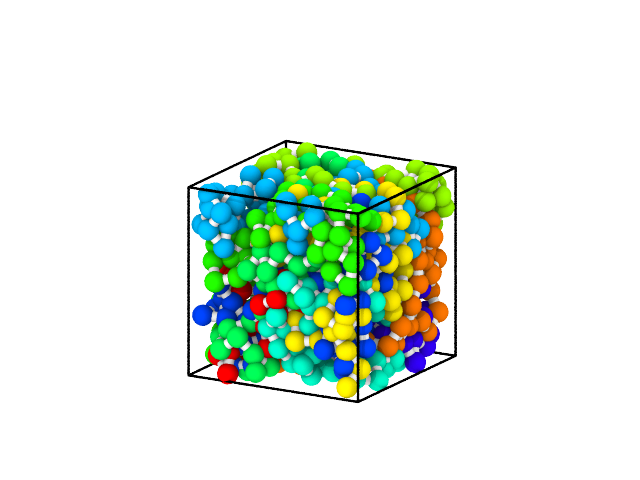